# 1.3 Grouping Data
Plotting each column with the date of each observation is useful to understand the historic behavior and to observe multiyear trends, but as you may noticed, most variable have strong seasonal (yearly) component. 
The function `plot_contents()` can be use to get insights into the yearly variation.

In [19]:
from funciones import*
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
Data=pd.read_csv("../../data/Time_series_DATA.txt",skiprows=149,index_col=0,sep="\t")
#Data=pd.read_csv('https://raw.githubusercontent.com/iceclassic/sandbox/main/Data/Time_series_DATA.txt',index_col=0,skiprows=149)
Data.index = pd.to_datetime(Data.index, format="%Y-%m-%d")

Data = Data[Data.index.year < 2022]

:::{card} Exercise 1
Read the documentation for `plot_contents()` plot the yearly variation of the columns `'Regional: Air temperature [C]'`and `'Gulkana Temperature [C]'`
:::

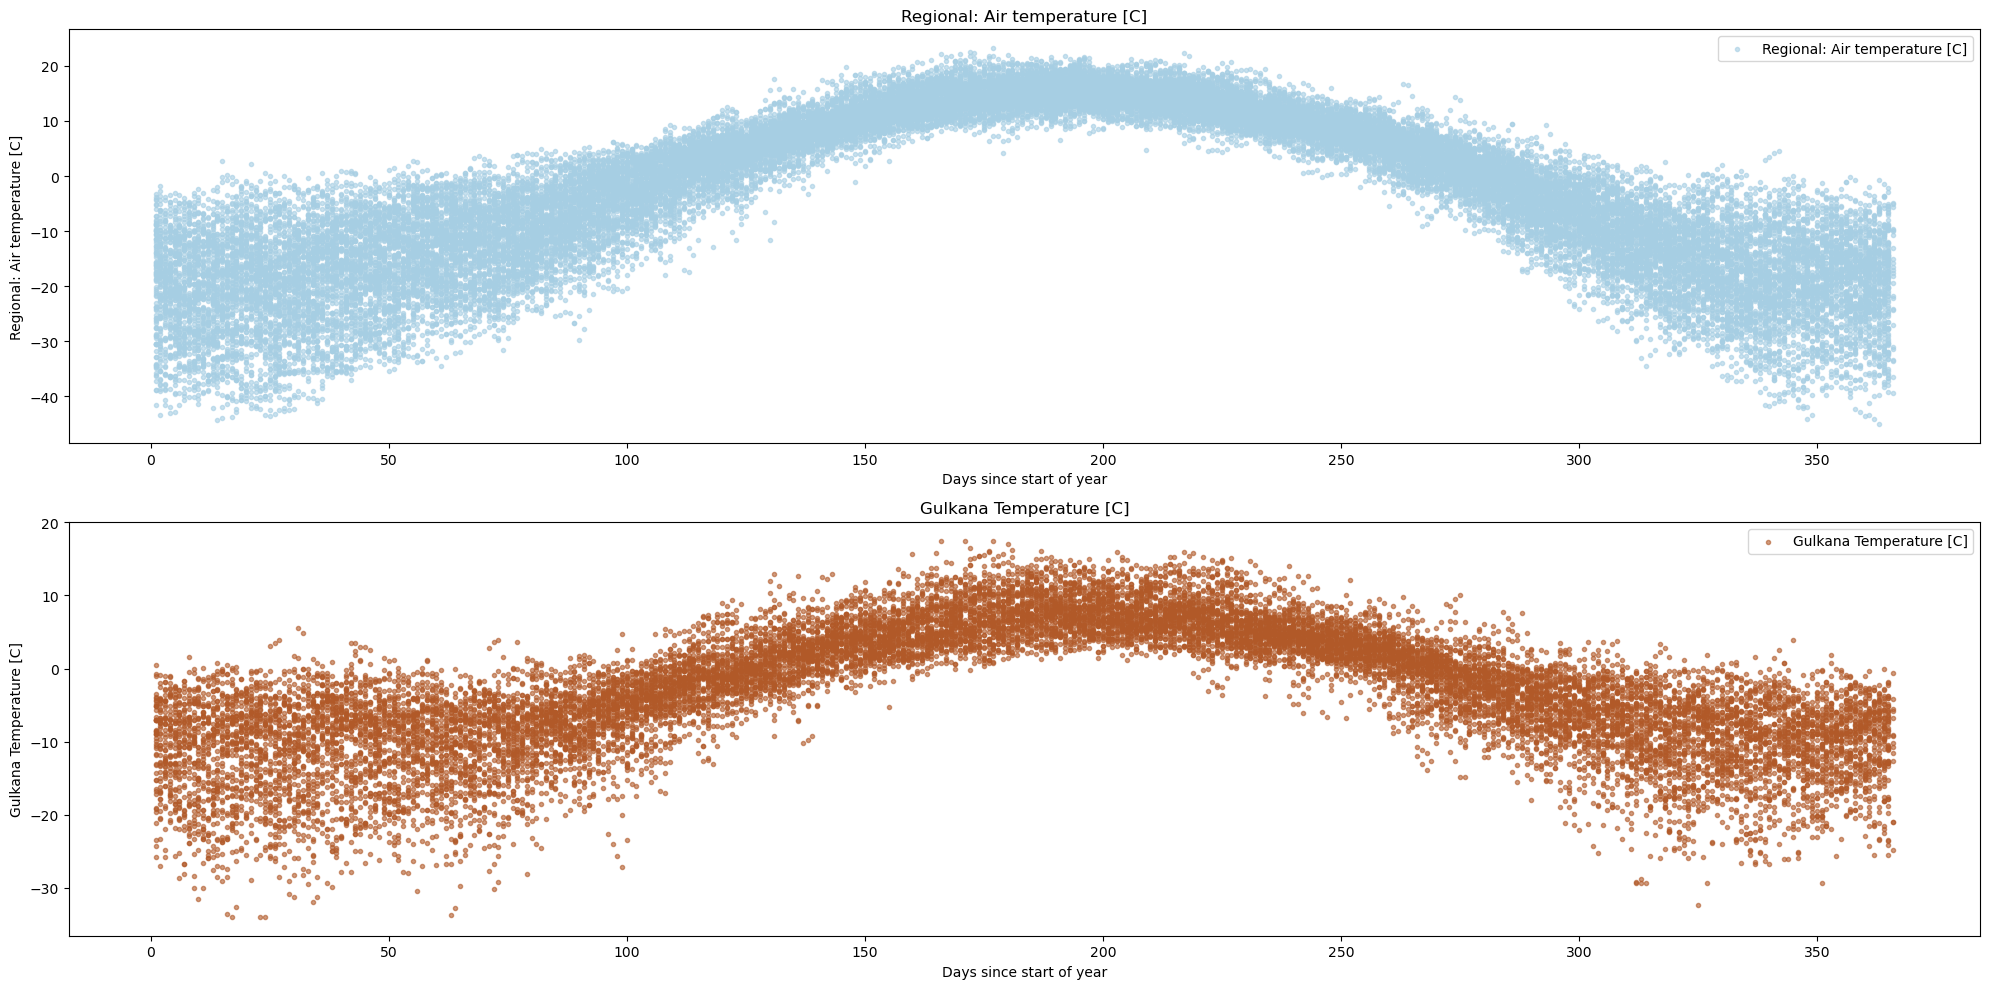

In [20]:
plot_contents(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],col_cmap='Paired',scatter_alpha=0.6)

Instead of plotting all the operation, plotting just  the mean and the standard deviation could be more useful.

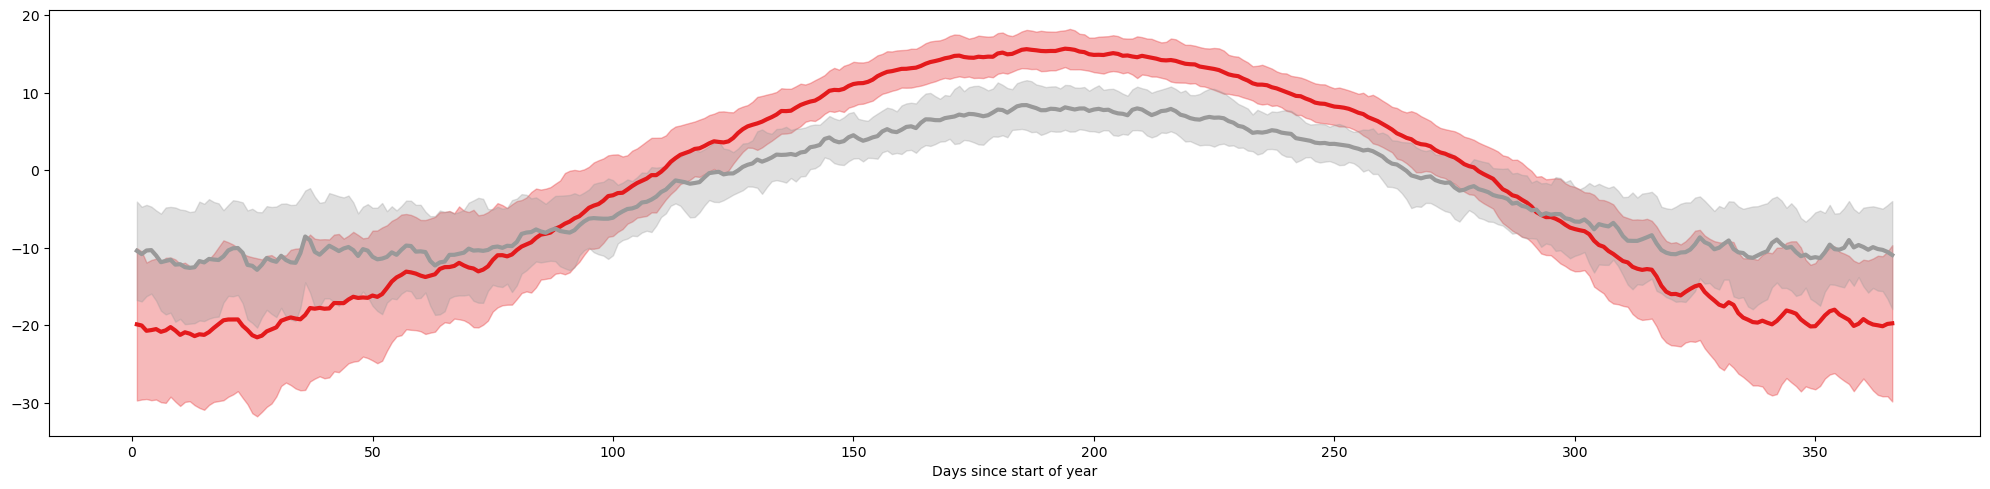

In [21]:
plot_contents(Data,columns_to_plot=['Regional: Air temperature [C]','Gulkana Temperature [C]'],plot_together=True,plot_mean_std='only',k=1)

:::{card} Exercise 3

Use  the argument  `multiyear`  to plot the data corresponding to the years 2009 and 2015 over the mean.

:::

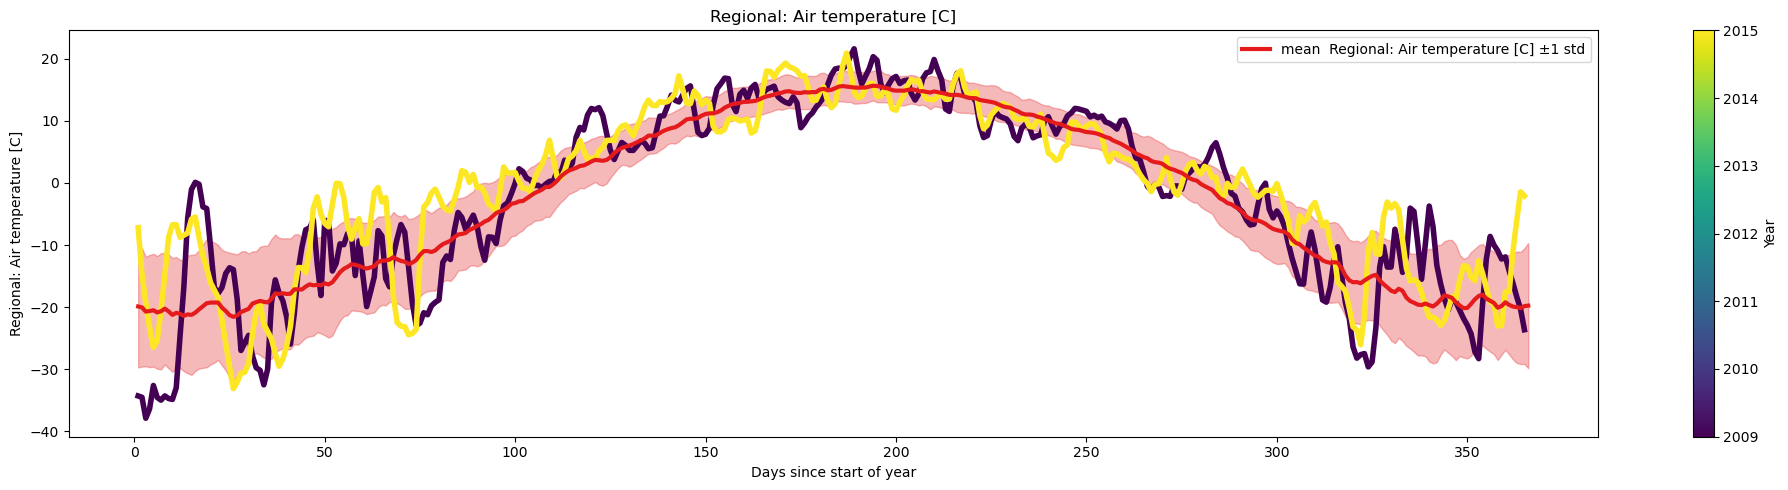

In [22]:
selected_years = [2009,2015]
plot_contents(Data,k=1,plot_mean_std='only',multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'])

By default the function uses `xaxis='Days since start of year'`, but any other column name can be selected. 


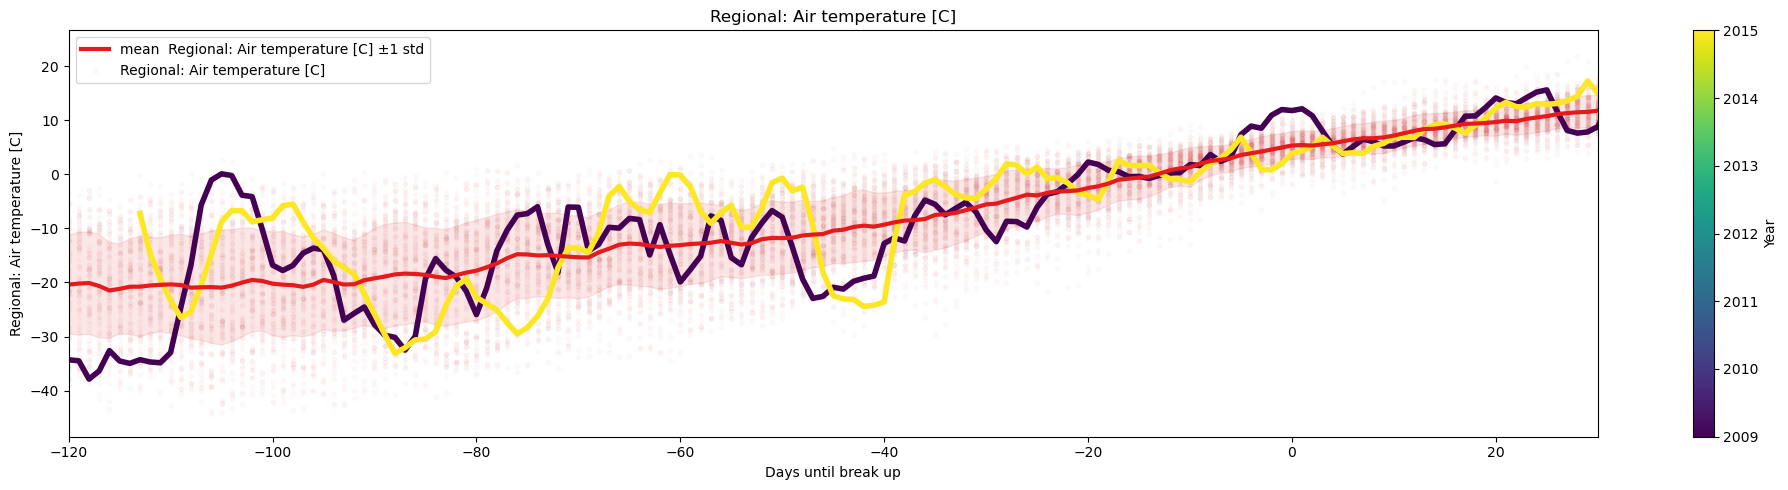

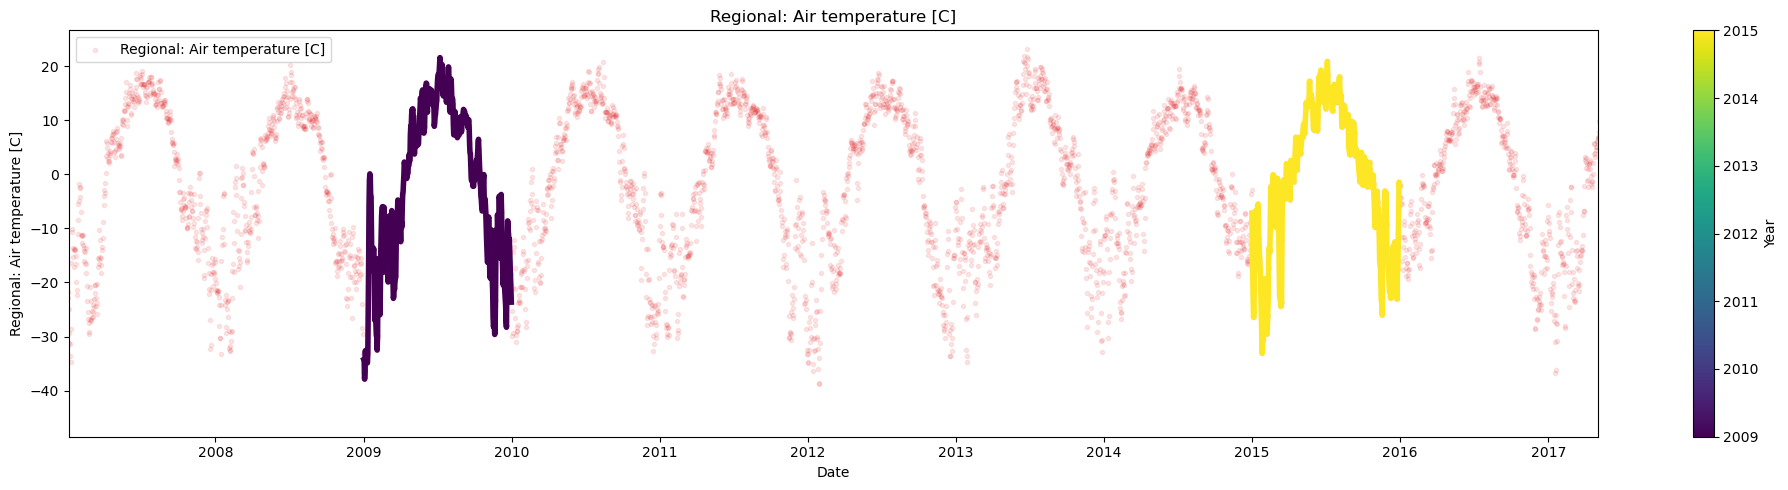

In [23]:
plot_contents(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Days until break up',xlim=[-120,30],
              plot_mean_std='true',scatter_alpha=.02,std_alpha=.1) 

plot_contents(Data,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],xaxis='index',xlim=['2007/01/04','2017/05/03']) 

Grouping the data into bins corresponding to each year in a natural yet completely arbitration choice, there is nothing special about january first or december 31. More likely another date or event/milestone is more meaningful, for example For instance, choosing `xaxis='Days until break-up'` allows us to observe trends leading up to the ice break-up, or choosing `xaxis=index` recovers the timeseries plot.


If we wanted to use another grouping or 'x-axis' we would need to create a new DataFrame , merge it to the original DataFrame and use the previous function.

> Beginner of winter and astronomical winter solstice
> mention that in higher latitudes the shortest day/earliest sunset differs from 21 dec, https://gml.noaa.gov/grad/solcalc/ 
> look for my spreadsheet with the Analemma ( implement in python for Nenana?  maybe too extra for this notebook)


:::{card} Exercise 2
Use `days_since_last_date()`to plot the temperature variation  since the start of winter.
:::

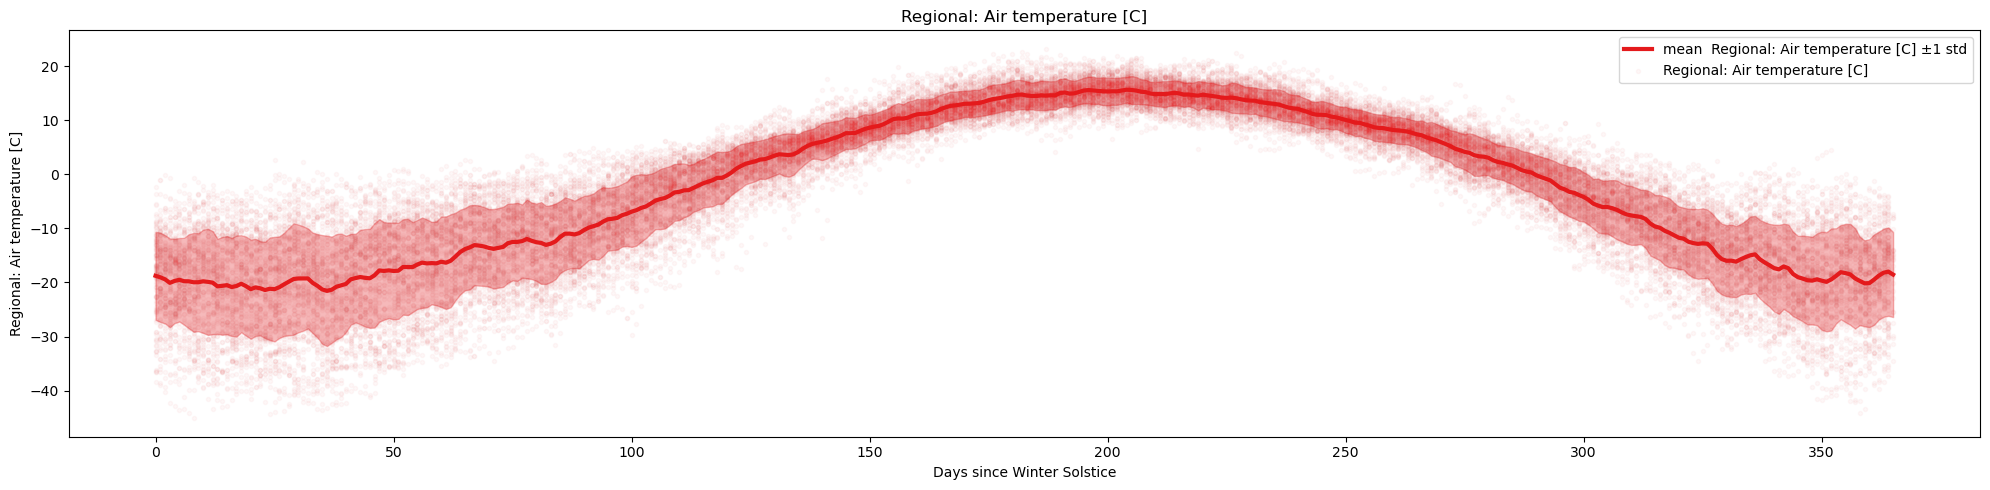

In [25]:
Data_2=days_since_last_date(Data,date='12/21',name='Winter Solstice')
plot_contents(Data_2,k=1,plot_mean_std=True,columns_to_plot=['Regional: Air temperature [C]'],xaxis='Winter Solstice',xaxis_name='Days since Winter Solstice',scatter_alpha=0.03)

## `groupby`,`transform` and `map` 

We have grouped the variables using the date(year) and the number of day since a specific date in each years, operations that can be be achieved relatively easy with pandas methods and/or with masks.

For more complex situations we need to *split-apply-combine*,  using `groupby`, `transform` and `map `. 

For example, lets try to re-create the plots above but considering the number of days since the river began to freeze.

:::{card}
Plot  `'IceThickness [cm]'` since the mean daily temperature was below zero for three consecutive days. 

**Naive Approach**

A simple approach would be to loop through each year and then through each day of that years to check wether the river has started to freeze.

Complete the missing lines
:::




In [ ]:
t1_0 = time.time()

freezing_dates_1 = []
for year in Data.index.year.unique():                     # Looping through years
    df_year = Data[Data.index.year == year].copy()        # Extracting data for that year
    df_year['Rolling Mean'] = df_year['Regional: Air temperature [C]'].rolling(window=3).mean()  # Compute rolling mean

    Frozen = False  # Initial state
    
    for i in range(3, len(df_year)):                      # Looping through days of that year, starting from day 3
        T_current = df_year.at[df_year.index[i], 'Regional: Air temperature [C]']   # .at is a little bit faster than .loc when extracting a single value from df
        T_rolling_mean = df_year.at[df_year.index[i], 'Rolling Mean']
        T_rolling_mean_prev = df_year.at[df_year.index[i-1], 'Rolling Mean']  # Previous day's rolling mean
        if T_rolling_mean < 0 and T_rolling_mean_prev >= 0:  # Condition for freezing
            Frozen=True
            freezing_dates_1.append(df_year.index[i].strftime('%Y/%m/%d'))

t1_f = time.time()  # Record the end time
delta_t1 = t1_f - t1_0
print(f"Elapsed time: {delta_t1:.4f} seconds")

Elapsed time: 3.3152 seconds


**Vector approach**

Just like in `numpy`, we can get reat performance improvements if we vectorize the code.
The method [`.groupby`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) is used to *split* the dataframe into a group based on some criteria, then the method [`.transform`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transform.html) can be use to apply a functions to the elements of group.


In [26]:
t2_0 = time.time()

rolling_avg_below_zero = Data['Regional: Air temperature [C]'].rolling(window=3).mean().lt(0) # method lt is less than and return boolean
Data['starting_to_freeze'] = rolling_avg_below_zero.groupby(Data.index.year).transform(lambda x: x & ~x.shift(1, fill_value=False))

t2_f = time.time()  # Record the end time
delta_t2 = t2_f - t2_0
print(f"Elapsed time: {delta_t2:.4f} seconds")
# extrating the dates to check

Elapsed time: 0.0661 seconds


This example is extreme but it illustrates that the vector approach could be orders of magnitude faster.

As we mentioned before, `.transform` applies a function to thr group, if the logic/expression is simple we can use python's [lambda function](https://docs.python.org/3/reference/expressions.html). 

`lambda `expressions are temporary and anonymous function that allows to evaluate an expression in a single line, without necessary defining the function. 


:::{card}



:::


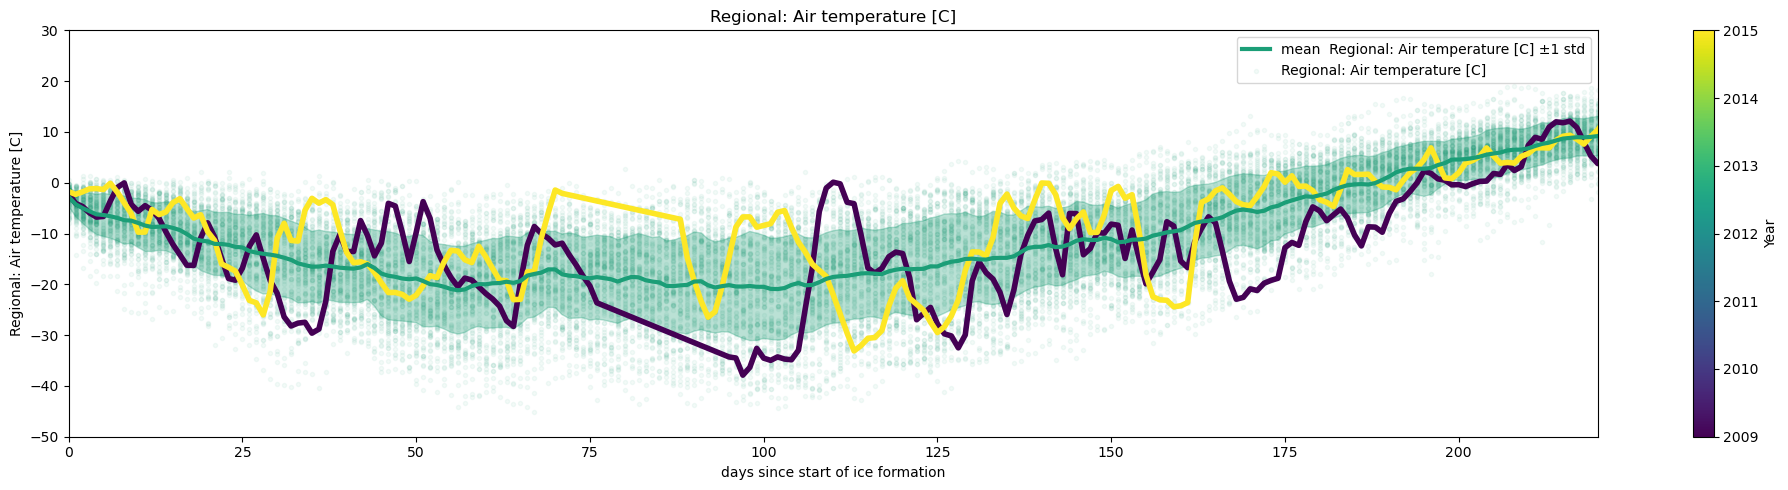

In [32]:
dates_of_occurrences = Data[Data['starting_to_freeze']].index.strftime('%Y/%m/%d').tolist()
#print(dates_of_occurrences)

# given the logic used in transform, we could have multiple days of starting to  freezng , for example an early cold wave that causes the mean to be below zero for a few days, then
# we assume that this cold wave was  too short to produce any ice, or that the ice formed melted after the cold wave passed, then we care about the last starting to freeze as it 
# correspond to the freezing period that continues through the winter 
#
dates_df = pd.DataFrame(pd.to_datetime(Data[Data['starting_to_freeze']].index.strftime('%Y/%m/%d')), columns=['date'])
dates_df['year'] = dates_df['date'].dt.year
latest_dates_formatted = dates_df.groupby('year')['date'].max().dt.strftime('%Y/%m/%d').tolist()

#print(latest_dates_formatted)


Data=days_since_last_date(Data,date=latest_dates_formatted,name='days since start of ice formation')

plot_contents(Data,plot_mean_std=True,multiyear=selected_years,columns_to_plot=['Regional: Air temperature [C]'],
              xaxis='days since start of ice formation',scatter_alpha=0.05,col_cmap='Dark2',k=1,xlim=[0,220],ylim=[[-50,30],[0,200]])





filtered_data = Data[Data['first_below_zero']]
dates_of_occurrences = filtered_data.index.strftime('%Y/%m/%d').tolist()
dates_of_occurrences = pd.to_datetime(dates_of_occurrences)
dates_df = pd.DataFrame(dates_of_occurrences, columns=['date'])
dates_df['year'] = dates_df['date'].dt.year
latest_dates = dates_df.groupby('year')['date'].max()
latest_dates_formatted = latest_dates.dt.strftime('%Y/%m/%d').tolist()